# IMPORT LIBRARY

In [2]:
!pip install google-play-scraper
from google_play_scraper import Sort, reviews
from google_play_scraper import app

!pip install openpyxl
import nltk
nltk.download('punkt')

!pip install wordcloud==1.9.4


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 40.1 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [3]:
import pandas as pd
import numpy as np
import csv

# SCRAPING

In [4]:
def scrape_google_play_reviews(app_id, num_reviews=100):
    reviews_list = []
    count = 0

    while count < num_reviews:
        try:
            result, _ = reviews(
                app_id,
                lang='id',
                country='id',
                sort=Sort.NEWEST,
                count=min(100, num_reviews - count)
            )
            reviews_list.extend(result)
            count += len(result)

            if len(result) < 100:
                break
        except Exception as e:
            print(f"Error: {e}")
            break

    return pd.DataFrame(reviews_list)

app_id = 'id.co.linebank'
num_reviews = 40000
df = scrape_google_play_reviews(app_id, num_reviews)
df.to_csv('data_ulasan.csv', index=False)

# PREPROCESSING

## FEATURE SELECTION

In [5]:
df = df[['content']]
df.rename(columns={'content': 'Ulasan'}, inplace=True)
df.to_csv('data_ulasan_feature_selection.csv', index=False)

total_ulasan = len(df)
print(f'Total data ulasan: {total_ulasan}')

Total data ulasan: 25144


## CLEANING

In [6]:
import pandas as pd
import re
import string

df = pd.read_csv('data_ulasan_feature_selection.csv')

# angka
def remove_number(text):
    return re.sub(r"\d+", " ", text)

# pengulangan huruf
def remove_repeated_chars(text):
    return re.sub(r'(.)\1{2,}', r'\1', text)

# tanda baca
def remove_punctuation(text):
    return text.translate(str.maketrans("", "", string.punctuation))

# link dan karakter non-ASCII
def remove_links(text):
    text = text.replace('\\t', " ").replace('\\n', " ").replace('\\u', " ").replace('\\', "")
    # mention, link, dan hashtag
    text = ' '.join(re.sub("([@#][A-Za-z0-9]+)|(\w+:\/\/\S+)", " ", text).split())
    # URL
    text = text.replace("http://", " ").replace("https://", " ")
    # karakter non-ASCII
    return re.sub(r'[^\x00-\x7F]+', '', text)

df['Ulasan_cleaning'] = df['Ulasan'].apply(remove_number)
df['Ulasan_cleaning'] = df['Ulasan_cleaning'].apply(remove_repeated_chars)
df['Ulasan_cleaning'] = df['Ulasan_cleaning'].apply(remove_punctuation)
df['Ulasan_cleaning'] = df['Ulasan_cleaning'].apply(remove_links)

df.to_csv('data_ulasan_cleaning.csv', index=False)

total_ulasan = len(df)
print(f'Total data ulasan: {total_ulasan}')

Total data ulasan: 25144


## CASE FOLDING

In [7]:
df = pd.read_csv('data_ulasan_cleaning.csv')
df['Ulasan_case_folding'] = df['Ulasan_cleaning'].str.lower()
df.to_csv('data_ulasan_case_folding.csv', index=False)

total_ulasan = len(df)
print(f'Total data ulasan: {total_ulasan}')

Total data ulasan: 25144


## TOKENISASI

In [23]:
import string
import re
import nltk
from nltk.tokenize import word_tokenize

# Download the required NLTK data
nltk.download('punkt_tab')

df = pd.read_csv('data_ulasan_case_folding.csv')
df['Ulasan_case_folding'] = df['Ulasan_case_folding'].fillna('')

def word_tokenize_wrapper(text):
    return word_tokenize(text)

df['Ulasan_tokenize'] = df['Ulasan_case_folding'].apply(word_tokenize_wrapper)
df.to_csv('data_ulasan_tokenize.csv', index=False)

print(f'Total data ulasan: {len(df)}')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
Total data ulasan: 25144


## STEMMING

In [41]:
 pip install Sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 28.6 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [42]:
import pandas as pd
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.tokenize import word_tokenize
import nltk
import ast

nltk.download('punkt')

factory = StemmerFactory()
stemmer = factory.create_stemmer()

df = pd.read_csv('/work/data_ulasan_tokenize.csv')

def convert_to_list(text):
    if isinstance(text, str):
        try:
            return ast.literal_eval(text)
        except (ValueError, SyntaxError):
            return text.split()
    return text

def stem_tokens(tokens):
    return [stemmer.stem(token) for token in tokens]

df['Ulasan_tokenize'] = df['Ulasan_tokenize'].apply(convert_to_list)
df['Ulasan_stemming'] = df['Ulasan_tokenize'].apply(stem_tokens)
df.to_csv('/work/CASE 1/data_ulasan_stemming.csv', index=False)

print(f'Total data ulasan: {len(df)}')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


KeyboardInterrupt: 

## NORMALISASI

In [29]:
import pandas as pd
import ast

indo_slang_word_url = "https://raw.githubusercontent.com/nasalsabila/kamus-alay/master/colloquial-indonesian-lexicon.csv"
indo_slang_word = pd.read_csv(indo_slang_word_url)

def normalize_tokens(tokens):
    normalized_tokens = []
    for token in tokens:
        external_match = indo_slang_word[indo_slang_word['slang'] == token]
        if not external_match.empty:
            normalized_tokens.append(external_match['formal'].values[0])
        else:
            normalized_tokens.append(token)
    return normalized_tokens

df = pd.read_csv('/work/data_ulasan_stemming.csv')

def ensure_list_format(text):
    try:
        return ast.literal_eval(text) if isinstance(text, str) else text
    except (ValueError, SyntaxError):
        return []

df['Ulasan_stemming'] = df['Ulasan_stemming'].apply(ensure_list_format)
df['Ulasan_normalisasi'] = df['Ulasan_stemming'].apply(normalize_tokens)
df.to_csv('/work/data_ulasan_normalisasi.csv', index=False)

print(f'Total data ulasan: {len(df)}')

KeyboardInterrupt: 

In [32]:
import pandas as pd
import ast

df = pd.read_csv('/work/data_ulasan_normalisasi.csv')

# Custom lexicon
slank_word_dict = {
    "agak": "sedikit", "pas": "saat", "nggak": "tidak", "kagak": "tidak", "kgk": "tidak",
    "tdk": "tidak", "gak": "tidak", "ga": "tidak", "gk": "tidak", "egk": "tidak", "enggak": "tidak",
    "jd": "jadi", "cpt": "cepat", "sdh": "sudah", "bisa": "dapat", "tf": "transfer", "e wallet": "e_wallet",
    "bs": "dapat", "bsa": "dapat", "recommend": "rekomendasi", "bagis": "bagus", "top up": "top_up",
    "recomended": "rekomendasi", "recommended": "rekomendasi", "rekomendasi": "rekomendasi",
    "lelet": "lama", "lambat": "lama", "lola": "lama", "buruk": "jelek", "busuk": "jelek",
    "rumit": "sulit", "ribet": "sulit", "repot": "sulit", "susah": "sulit", "sh": "sih",
    "mantul": "bagus", "mantap": "bagus", "ok": "bagus", "oke": "bagus", "cs": "customer_service",
    "gw": "saya", "gue": "saya", "w": "saya", "q": "saya", "sy": "saya", "aq": "saya",
    "gua": "saya", "lu": "kamu", "lo": "kamu", "u": "kamu", "km": "kamu", "kmu": "kamu",
    "loe": "kamu", "yg": "yang", "jg": "juga", "trs": "terus", "dgn": "dengan",
    "utk": "untuk", "spy": "supaya", "skrg": "sekarang", "sgt": "sangat", "krn": "karena",
    "hrs": "harus", "tp": "tapi", "tpi": "tapi", "td": "tadi", "dr": "dari", "dll": "dan lain lain",
    "dsb": "dan sebagainya", "lg": "lagi", "byk": "banyak", "kyk": "seperti",
    "kyak": "seperti", "kayak": "seperti", "udh": "sudah", "udah": "sudah", "keren": "bagus",
    "lemot": "lama", "apk": "aplikasi", "mantab": "bagus", "mantaps": "bagus", "mantapz": "bagus"
}

def normalize_custom(tokens):
    return [slank_word_dict.get(token, token) for token in tokens]

def convert_to_list(text):
    if isinstance(text, str):
        try:
            return ast.literal_eval(text)
        except (ValueError, SyntaxError):
            return text.split()
    return text

df['Ulasan_normalisasi'] = df['Ulasan_normalisasi'].apply(convert_to_list)
df['Ulasan_normalisasi'] = df['Ulasan_normalisasi'].apply(normalize_custom)
df.to_csv('data_ulasan_normalisasi_final.csv', index=False)

print(f'Total data ulasan: {len(df)}')

Total data ulasan: 12625


## STOPWORD REMOVAL

In [35]:
import pandas as pd

InSetp = pd.read_csv('/work/positive.csv')  # InSet Lexicon Positive
InSetn = pd.read_csv('/work/negative.csv')  # InSet Lexicon Negative
stopword_dict = pd.read_csv('/work/stopwords_indonesian.txt', header=None, names=['word'])  #NLTK STOPWORD

all_words_set = set(InSetp['word']).union(set(InSetn['word']))

stopword_dict_filtered = stopword_dict[~stopword_dict['word'].isin(all_words_set)]

with open('stopwords_indonesian_modified.txt', 'w') as f:
    f.write("\n".join(stopword_dict_filtered['word']))

In [38]:
import pandas as pd
import nltk
import ast  

nltk.download('punkt')

with open('/work/stopwords_indonesian_modified.txt', 'r') as f:
    stopwords = set(f.read().splitlines())
df = pd.read_csv('/work/CASE 1/data_ulasan_normalisasi_final.csv')

def convert_to_list(text):
    if isinstance(text, str):
        try:
            return ast.literal_eval(text)  
        except (ValueError, SyntaxError):
            return text.split() 
    return text


def remove_stopwords(tokens):
    return [token for token in tokens if token not in stopwords]

df['Ulasan_normalisasi_final'] = df['Ulasan_normalisasi_final'].apply(convert_to_list)
df['Ulasan_stopword'] = df['Ulasan_normalisasi_final'].apply(remove_stopwords)
df.to_csv('/work/CASE 1/data_ulasan_stopword.csv', index=False)


total_ulasan = len(df)
print(f'Total data ulasan: {total_ulasan}')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Total data ulasan: 12625


In [45]:
df = pd.read_csv('/work/CASE 1/data_ulasan_stopword.csv')
df.rename(columns={'Ulasan_stopword': 'Ulasan_preprocessing'}, inplace=True)
df = df[['Ulasan_preprocessing']]
df.to_csv('/work/CASE 1/data_ulasan_preprocessing.csv', index=False)

# KLASIFIKASI SENTIMEN (LEXICON-BASED)

## klasifikasi menggunakan InSet Lexicon

In [48]:
lexicon_positive = dict()
import csv
with open('/work/positive.tsv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter='\t')
    next(reader)
    for row in reader:
        lexicon_positive[row[0]] = int(row[1])

lexicon_negative = dict()
with open('/work/negative.tsv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter='\t')
    next(reader)
    for row in reader:
        lexicon_negative[row[0]] = int(row[1])

def sentiment_analysis_lexicon_indonesia(tokens):
    score = 0
    sentiments = []
    for token in tokens:
        if token in lexicon_positive:
            sentiment = f"{token}(+{lexicon_positive[token]})"
            sentiments.append(sentiment)
            score += lexicon_positive[token]
        if token in lexicon_negative:
            sentiment = f"{token}({lexicon_negative[token]})"
            sentiments.append(sentiment)
            score += lexicon_negative[token]
    polarity = ''
    if score > 0:
        polarity = 'positive'
    elif score < 0:
        polarity = 'negative'
    else:
        polarity = 'neutral'
    return score, polarity, ', '.join(sentiments)

import pandas as pd

df = pd.read_csv('/work/CASE 1/data_ulasan_preprocessing.csv')
df['Ulasan_preprocessing'] = df['Ulasan_preprocessing'].apply(eval)
df['Sentiment_Score'], df['Sentiment_Polarity'], df['Sentiment_Detail'] = zip(*df['Ulasan_preprocessing'].apply(sentiment_analysis_lexicon_indonesia))
df = df[['Ulasan_preprocessing', 'Sentiment_Score', 'Sentiment_Polarity', 'Sentiment_Detail']]

df.to_csv('/work/CASE 1/sentiment_analysis.csv', index=False)

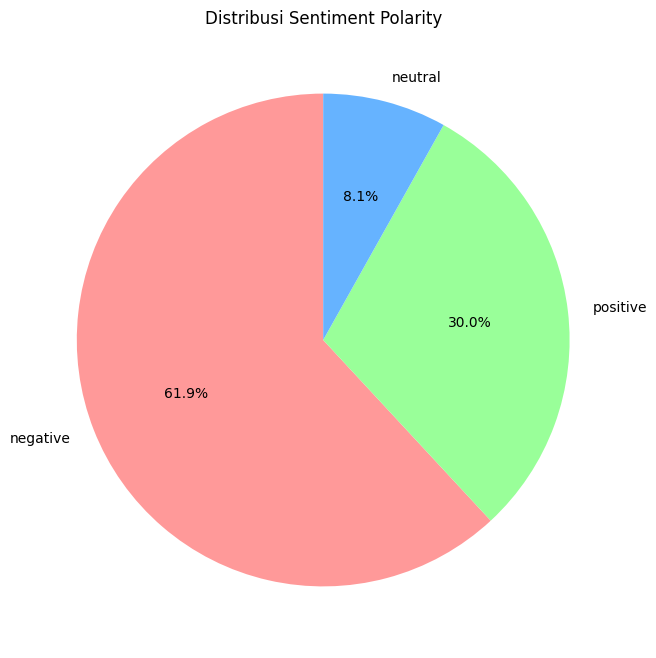

Sentiment_Polarity
negative    7815
positive    3784
neutral     1026
Name: count, dtype: int64

In [51]:
import matplotlib.pyplot as plt

# Count the sentiment polarity distribution
df = pd.read_csv('/work/CASE 1/sentiment_analysis.csv')
sentiment_counts = df['Sentiment_Polarity'].value_counts()

# Plot the pie chart
plt.figure(figsize=(8, 8))
sentiment_counts.plot.pie(autopct='%1.1f%%', startangle=90, colors=['#ff9999', '#99ff99', '#66b3ff'])
plt.title('Distribusi Sentiment Polarity')
plt.ylabel('')
plt.savefig('sentiment_pie_chart.png')
plt.show()

# Display the counts
sentiment_counts

In [54]:
import pandas as pd

ulasan_df = pd.read_csv('/work/CASE 1/sentiment_analysis.csv')
sample_data = ulasan_df.sample(frac=0.1, random_state=42)
sample_data.to_excel('/work/CASE 1/pengujian.xlsx', index=False)

# VISUALISASI

In [57]:
import pandas as pd

df = pd.read_csv('/work/CASE 1/sentiment_analysis.csv')
df = df.loc[df['Sentiment_Polarity'] == 'negative']
df.to_csv('/work/CASE 1/sentiment_negative.csv', index=False)

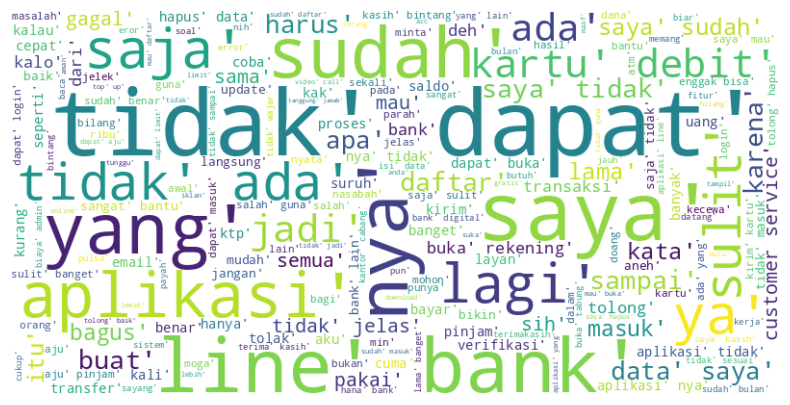

In [60]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

df = pd.read_csv('/work/CASE 1/sentiment_negative.csv')
all_text = ' '.join([' '.join(item) if isinstance(item, list) else str(item) for item in df['Ulasan_preprocessing']])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# BIGRAM

In [66]:
import pandas as pd
from nltk.util import bigrams
from collections import Counter
import matplotlib.pyplot as plt

ulasan_df = pd.read_csv('/work/CASE 1/sentiment_negative.csv')

import ast
ulasan_df['Ulasan_preprocessing'] = ulasan_df['Ulasan_preprocessing'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

def generate_bigrams(tokens):
    return [" ".join(bigram) for bigram in bigrams(tokens)]

ulasan_df['bigrams'] = ulasan_df['Ulasan_preprocessing'].apply(generate_bigrams)
all_bigrams = [bigram for bigrams_list in ulasan_df['bigrams'] for bigram in bigrams_list]
bigram_counts = Counter(all_bigrams)

bigram_df = pd.DataFrame(bigram_counts.items(), columns=['bigram', 'frequency'])
bigram_df.to_csv('/work/CASE 1/bigrams.csv', index=False)

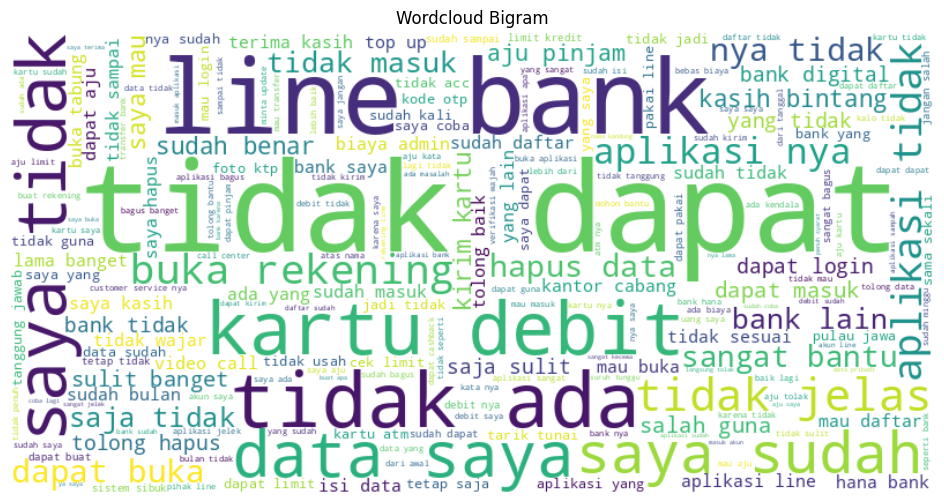

In [69]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

bigram_dict = dict(bigram_counts)

wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white', 
    colormap='viridis'
).generate_from_frequencies(bigram_dict)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Wordcloud Bigram")
plt.show()

## TOP 100 BIGRAM

In [72]:
import pandas as pd
from nltk.util import bigrams
from collections import Counter

ulasan_df = pd.read_csv('/work/CASE 1/sentiment_negative.csv')

import ast
ulasan_df['Ulasan_preprocessing'] = ulasan_df['Ulasan_preprocessing'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

def generate_bigrams(tokens):
    return [" ".join(bigram) for bigram in bigrams(tokens)]

ulasan_df['bigrams'] = ulasan_df['Ulasan_preprocessing'].apply(generate_bigrams)
all_bigrams = [bigram for bigrams_list in ulasan_df['bigrams'] for bigram in bigrams_list]
bigram_counts = Counter(all_bigrams)

top_100_bigrams = bigram_counts.most_common(100)
top_100_bigrams_df = pd.DataFrame(top_100_bigrams, columns=['bigram', 'frequency'])
top_100_bigrams_df.to_csv('/work/CASE 1/top_100_bigrams.csv', index=False)

print(f"100 bigram dengan frekuensi tertinggi telah disimpan ke '/work/CASE 1/top_100_bigrams.csv'")

100 bigram dengan frekuensi tertinggi telah disimpan ke '/work/CASE 1/top_100_bigrams.csv'


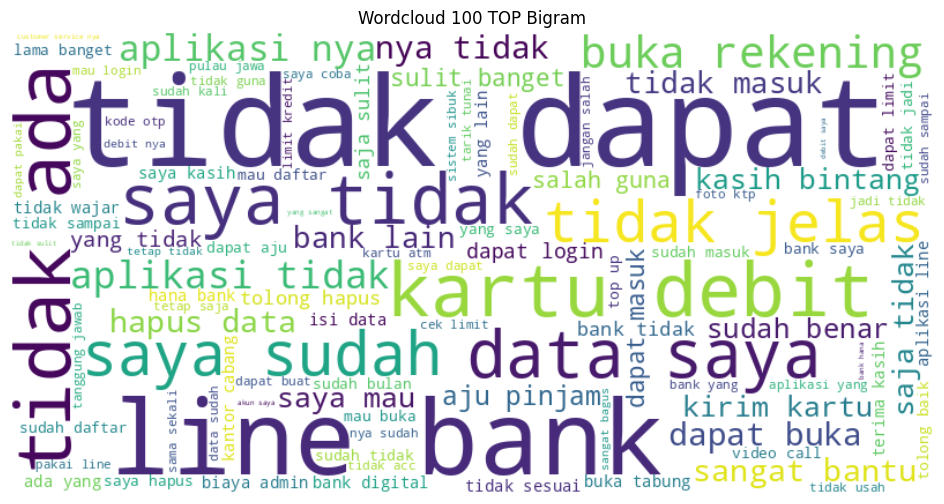

In [75]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

bigram_dict = dict(top_100_bigrams)

wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white', 
    colormap='viridis'
).generate_from_frequencies(bigram_dict)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Wordcloud 100 TOP Bigram")
plt.show()

In [4]:
import pandas as pd
import ast

# Baca file hasil preprocessing
df = pd.read_csv('/work/CASE 1/sentiment_negative.csv')

# Pastikan kolom Ulasan_preprocessing berupa list
df['Ulasan_preprocessing'] = df['Ulasan_preprocessing'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

# Fungsi untuk memeriksa apakah sebuah bigram ada dalam ulasan
def contains_bigram(tokens, bigram):
    for i in range(len(tokens) - 1):
        if f"{tokens[i]} {tokens[i+1]}" == bigram:
            return True
    return False

# Bigram yang ingin dicari
target_bigram = "tidak dapat"  # Ganti dengan bigram lain jika diperlukan

# Filter ulasan yang mengandung bigram
filtered_ulasan = df[df['Ulasan_preprocessing'].apply(lambda tokens: contains_bigram(tokens, target_bigram))]

# Tampilkan ulasan yang mengandung bigram
print(f"Ulasan yang mengandung bigram '{target_bigram}':")
for index, row in filtered_ulasan.iterrows():
    print(f"- {row['Ulasan_preprocessing']}")

- ['tidak', 'jelas', 'aplikasi', 'sampah', 'awal', 'dapat', 'limit', 'juta', 'suruh', 'buka', 'tabung', 'buka', 'buku', 'tabung', 'sudah', 'selesai', 'limit', 'tidak', 'dapat', 'pakai', 'alas', 'domisili', 'domisili', 'ada', 'dijobodetabek', 'yang', 'kata', 'dapat', 'tidak', 'jelas', 'uninstall', 'lagi']
- ['kali', 'kali', 'tidak', 'dapat', 'login', 'lewat', 'line']
- ['tidak', 'dapat', 'masuk', 'sulit', 'banget']
- ['saya', 'sudah', 'punya', 'kartu', 'kredit', 'nya', 'knapa', 'saya', 'tidak', 'dapat', 'masuk', 'lagi', 'aplikasi', 'nyagimana', 'nya', 'biar', 'saya', 'dapat', 'masuk']
- ['saldo', 'saya', 'akun', 'line', 'tidak', 'dapat', 'buat', 'transaksi', 'transfer']
- ['ganggu', 'mulu', 'ya', 'mau', 'masuk', 'akun', 'tidak', 'dapat']
- ['tidak', 'dapat', 'login', 'customer service', 'tidak', 'dapat', 'bantu', 'guna', 'buka', 'rekening', 'buat', 'apa', 'kartu', 'atm', 'tidak', 'sampai', 'rumah', 'sekian']
- ['pliskenapa', 'mau', 'daftar', 'saja', 'sulit', 'sampai', 'bikin', 'email', 

In [7]:
import pandas as pd
import ast

# Baca file hasil preprocessing
df = pd.read_csv('/work/CASE 1/sentiment_negative.csv')

# Pastikan kolom Ulasan_preprocessing berupa list
df['Ulasan_preprocessing'] = df['Ulasan_preprocessing'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

# Fungsi untuk memeriksa apakah sebuah trigram ada dalam ulasan
def contains_trigram(tokens, trigram):
    for i in range(len(tokens) - 2):
        if f"{tokens[i]} {tokens[i+1]} {tokens[i+2]}" == trigram:
            return True
    return False

# Trigram yang ingin dicari
target_trigram = "line bank karena"  # Ganti dengan trigram lain jika diperlukan

# Filter ulasan yang mengandung trigram
filtered_ulasan = df[df['Ulasan_preprocessing'].apply(lambda tokens: contains_trigram(tokens, target_trigram))]

# Tampilkan ulasan yang mengandung trigram
print(f"Ulasan yang mengandung trigram '{target_trigram}':")
for index, row in filtered_ulasan.iterrows():
    print(f"- {row['Ulasan_preprocessing']}")


Ulasan yang mengandung trigram 'line bank karena':
- ['rabu', 'aplikasi', 'line', 'bank', 'saya', 'uninstal', 'karena', 'aju', 'pinjam', 'saya', 'tolak', 'data', 'saya', 'disalahgunakan', 'saya', 'lapor', 'kominfo', 'instansi', 'kait', 'saya', 'harap', 'data', 'saya', 'lindung', 'line', 'bank', 'karena', 'mau', 'aju', 'hapus', 'akun', 'sangat', 'sulit', 'suruh', 'hubung', 'customer service', 'saya', 'buat', 'bukti', 'saya', 'jadi', 'penyalahgunaan', 'kait', 'data', 'saya', 'terima', 'kasih']
- ['jangan', 'mau', 'mengunakan', 'aplikasi', 'line', 'bank', 'karena', 'ada', 'saldo', 'pasti', 'blokir', 'line', 'bank']
- ['suka', 'sekali', 'line', 'bank', 'karena', 'ada', 'kuota', 'transfer', 'adm']
- ['awal', 'buka', 'tabung', 'line', 'bank', 'karena', 'ada', 'program', 'cashback', 'guna', 'walau', 'ada', 'sedikit', 'kendala', 'karena', 'reward', 'saya', 'tidak', 'cair', 'itu', 'sudah', 'selesai', 'lewat', 'adu', 'via', 'call', 'hana', 'guna', 'sih', 'bagus', 'banget', 'ui', 'nya', 'simple',

In [46]:
import pandas as pd
from nltk.util import trigrams
from collections import Counter
import ast

# Baca data dan pastikan 'Ulasan_preprocessing' list token
ulasan_df = pd.read_csv('/work/CASE 1/sentiment_negative.csv')
ulasan_df['Ulasan_preprocessing'] = ulasan_df['Ulasan_preprocessing'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

# Generate trigram list dari token ulasan
def generate_trigrams(tokens):
    return [" ".join(trigram) for trigram in trigrams(tokens)]

ulasan_df['trigrams'] = ulasan_df['Ulasan_preprocessing'].apply(generate_trigrams)

# Hitung frekuensi semua trigram
all_trigrams = [trigram for trigram_list in ulasan_df['trigrams'] for trigram in trigram_list]
trigram_counts = Counter(all_trigrams)

# Baca dataframe top 100 bigram hasil sebelumnya
top_100_bigrams_df = pd.read_csv('/work/CASE 1/top_100_bigrams.csv')

# Ambil list bigram dari kolom 'bigram'
top_100_bigrams_list = top_100_bigrams_df['bigram'].tolist()

# Cari top 10 trigram untuk masing-masing bigram
result = []
for bigram in top_100_bigrams_list:
    trigram_candidates = {tri: count for tri, count in trigram_counts.items() if tri.startswith(bigram + " ")}
    top_10_trigrams = sorted(trigram_candidates.items(), key=lambda x: x[1], reverse=True)[:10]
    for trigram, freq in top_10_trigrams:
        result.append({
            'bigram': bigram,
            'trigram': trigram,
            'frequency': freq
        })

# Buat dataframe hasil dan simpan ke Excel
trigrams_df = pd.DataFrame(result)
trigrams_df.to_excel('/work/CASE 1/top_100_bigrams_top_10_trigrams.xlsx', index=False)

print("File Excel dengan 10 trigram teratas per bigram sudah disimpan ke '/work/CASE 1/top_100_bigrams_top_10_trigrams.xlsx'")


File Excel dengan 10 trigram teratas per bigram sudah disimpan ke '/work/CASE 1/top_100_bigrams_top_10_trigrams.xlsx'


In [10]:
from nltk.util import ngrams
import random
ulasan_df = pd.read_csv('/work/CASE 1/sentiment_negative.csv')
# Buat kolom 4-grams
def generate_4grams(tokens):
    return [" ".join(ng) for ng in ngrams(tokens, 4)]

ulasan_df['fourgrams'] = ulasan_df['Ulasan_preprocessing'].apply(generate_4grams)

# Ambil daftar trigram dari file hasil sebelumnya
trigrams_df = pd.read_excel('/work/CASE 1/top_100_bigrams_top_10_trigrams.xlsx')
top_trigrams = trigrams_df['trigram'].unique().tolist()

# Simpan hasil akhir
hasil = []

for trigram in top_trigrams:
    # Filter baris yang punya 4-gram yang dimulai dengan trigram
    matching_rows = ulasan_df[ulasan_df['fourgrams'].apply(lambda fg_list: any(fg.startswith(trigram + " ") for fg in fg_list))]

    # Kumpulkan semua 4-gram yang cocok
    matching_fourgrams = []
    for _, row in matching_rows.iterrows():
        matching_fgs = [fg for fg in row['fourgrams'] if fg.startswith(trigram + " ")]
        for fg in matching_fgs:
            matching_fourgrams.append((fg, row['Ulasan_preprocessing']))  # Simpan 4gram dan ulasan aslinya

    # Ambil 10 contoh acak (jika tersedia)
    sample = random.sample(matching_fourgrams, min(10, len(matching_fourgrams)))

    for fg, review in sample:
        hasil.append({
            'trigram': trigram,
            '4gram': fg,
            'ulasan_token': " ".join(review)
        })


hasil_df = pd.DataFrame(hasil)
hasil_df.to_csv('/work/CASE 1/sample_4grams_per_trigram.csv', index=False)

print("File Excel dengan 10 contoh 4-gram dan ulasan untuk setiap trigram telah disimpan.")


File Excel dengan 10 contoh 4-gram dan ulasan untuk setiap trigram telah disimpan.


In [81]:
import pandas as pd
import ast

# Baca file hasil preprocessing
df = pd.read_csv('/work/CASE 1/sentiment_negative.csv')

# Pastikan kolom Ulasan_preprocessing berupa list
df['Ulasan_preprocessing'] = df['Ulasan_preprocessing'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

# Fungsi untuk memeriksa apakah sebuah bigram ada dalam ulasan
def contains_bigram(tokens, bigram):
    for i in range(len(tokens) - 1):
        if f"{tokens[i]} {tokens[i+1]}" == bigram:
            return True
    return False

# Bigram yang ingin dicari
target_bigram = "sulit login"  # Ganti dengan bigram lain jika diperlukan

# Filter ulasan yang mengandung bigram
filtered_ulasan = df[df['Ulasan_preprocessing'].apply(lambda tokens: contains_bigram(tokens, target_bigram))]

# Tampilkan ulasan yang mengandung bigram
print(f"Ulasan yang mengandung bigram '{target_bigram}':")
for index, row in filtered_ulasan.iterrows():
    print(f"- {row['Ulasan_preprocessing']}")

    # Simpan hasil ulasan yang mengandung bigram ke file CSV
filtered_ulasan.to_csv('/work/CASE 1/filtered_bigram_sulit_login.csv', index=False)

from collections import Counter

# Membuat list semua bigram dari seluruh data ulasan
all_bigrams = []

for tokens in df['Ulasan_preprocessing']:
    for i in range(len(tokens) - 1):
        bigram = f"{tokens[i]} {tokens[i+1]}"
        all_bigrams.append(bigram)

# Hitung frekuensi kemunculan tiap bigram
bigram_counter = Counter(all_bigrams)

# Konversi ke DataFrame agar mudah dilihat dan disimpan
bigram_df = pd.DataFrame(bigram_counter.items(), columns=['Bigram', 'Frequency'])

# Urutkan berdasarkan frekuensi tertinggi
bigram_df = bigram_df.sort_values(by='Frequency', ascending=False)

# Simpan ke file CSV
bigram_df.to_csv('/work/CASE 1/sulit_login.csv', index=False)

# Tampilkan 10 bigram paling sering muncul
print("10 Bigram paling sering muncul:")
print(bigram_df.head(10))

Ulasan yang mengandung bigram 'sulit login':
- ['makin', 'kesini', 'hp', 'android', 'makin', 'sulit', 'login', 'harus', 'nya', 'versi', 'baik', 'lebih', 'bagus', 'dari', 'pada', 'sulit', 'login', 'hp', 'android', 'lama']
- ['sulit', 'login', 'bolak', 'balik', 'tidak', 'dapat', 'masuk', 'sudah', 'ikut', 'prosedur', 'mending', 'pakai', 'biometrik']
- ['sulit', 'login', 'aplikasi']
- ['masuk', 'saja', 'jangan', 'terlalu', 'sulit', 'login', 'ulangcukup', 'otp', 'gmail', 'nomer', 'saja', 'sudah', 'cukup']
- ['parah', 'sulit', 'login']
- ['seperti', 'nya', 'sulit', 'login', 'nya', 'coba', 'yang', 'jenis', 'online', 'nih', 'cepat', 'jangan', 'seperti', 'getah', 'karet']
- ['minta', 'tolong', 'aku', 'sulit', 'login', 'kalau', 'lupa', 'password', 'verifikasi', 'ktp', 'sudah', 'benar', 'tidak', 'mau', 'login', 'tolong', 'kerjasamanya']
- ['aplikasi', 'rebit', 'sulit', 'login', 'daptar', 'ya', 'lama', 'acc', 'parah', 'nih', 'aplikasi', 'aplikasi', 'sulit', 'pinjol']
- ['aplikasi', 'bank', 'sulit'

# PENGUJIAN

Hasil Evaluasi Metrik:
Accuracy: 0.71
Precision: 0.69
Recall: 0.71
F1-Score: 0.70

Confusion Matrix:
              precision    recall  f1-score   support

    negative       0.76      0.89      0.82       673
     neutral       0.43      0.24      0.31       177
    positive       0.70      0.64      0.67       412

    accuracy                           0.71      1262
   macro avg       0.63      0.59      0.60      1262
weighted avg       0.69      0.71      0.70      1262



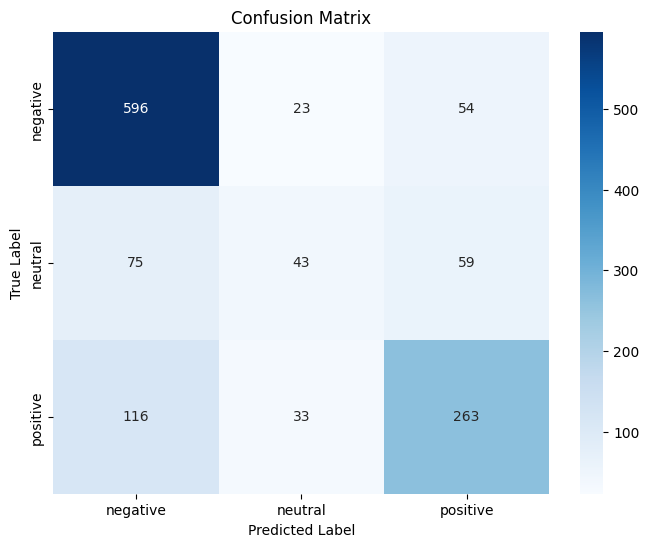

In [88]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

ulasan_df = pd.read_excel('/work/pengujian.xlsx')
y_true = ulasan_df['Labelling']
y_pred = ulasan_df['Sentiment_Polarity']

def evaluate_metrics(y_true, y_pred):
    """
    Menghitung metrik evaluasi berdasarkan dua kolom.
    """
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
   
    cm = confusion_matrix(y_true, y_pred)
    return accuracy, precision, recall, f1, cm

accuracy, precision, recall, f1, cm = evaluate_metrics(y_true, y_pred)

print("Hasil Evaluasi Metrik:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print("\nConfusion Matrix:")
print(classification_report(y_true, y_pred))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=set(y_true), yticklabels=set(y_true))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=57c40412-0747-4d24-b89b-6a094974f0c3' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>